# RNN/GRU Model: Text Classification & Sentiment Analysis

This project implements a neural network for classifying emotions in text. The dataset used for training and evaluation is a 20 000 line csv-file, each line containing a string along with one of six labels: 'anger', 'sadness', 'joy', 'love', 'fear' or 'surprise'.

A custom model has been created from the ground up with Keras. The data has been appropriately split into training, validation, and test sets. Activation functions and loss functions were selected to optimize performance.

**The project includes comprehensive prints of relevant metrics and visualizations of training curves.**

---

- *Data Preprocessing*: Removing unnecessary elements.
- *Model Architecture*:
   - *Activation Functions*: Softmax.
   - *Loss Function*: Categorical Crossentropy.
   - *Regularization Techniques*: Dropout in GRU-layer.
- *Evaluation*: Test data split from the train and inference on new unseen data.

- **Reflection and Future Improvements**:
   - The project reflects on the achieved performance and discusses potential enhancements.
   - Suggestions for further improvement are outlined, showcasing a critical evaluation of the project.

---

## Dataset Overview

The initial EDA provides insights into the dataset structure:

```plaintext
   text                                                    label
   count   20000                                           20000
   unique  19948                                           6
   top     i tend to stop breathing when i m feeling s...  joy
   freq    2                                               6761
```

The dataset comprises 20,000 entries, with 19,948 unique texts and six unique emotion labels. The most frequent emotion is 'joy' with 6,761 occurrences.

In [1]:
import pandas as pd
df = pd.read_csv('Data/emotions.csv') 
df.describe()

,text,label
count,20000,20000
unique,19948,6
top,i tend to stop breathing when i m feeling stre...,joy
freq,2,6761


In [2]:
df.columns

Index(['text', 'label'], dtype='object')

### Class Distribution Analysis


In [3]:
df['label'].value_counts()

label
joy         6761
sadness     5797
anger       2709
fear        2373
love        1641
surprise     719
Name: count, dtype: int64

The class distribution exhibits varying degrees of skewness, with 'joy' and 'Sadness' being the most prevalent emotions in the dataset. Adjustments may be considered to ensure the model achieves a balanced and accurate representation across all emotional categories.

In [4]:
df.sample(10)

,text,label
14117,i intend to have them develop feelings for one...,anger
18580,i feel tortured and tragic enough as it is wit...,anger
16564,im not planning to get hammered i warned feeli...,joy
16367,i feel really fucked up still,anger
10254,i felt a little bit of cramping and the same f...,anger
14350,i started feeling like i was being paranoid si...,fear
1401,i didn t feel rushed to finish millions of thi...,anger
14689,i may feel uncomfortable or just want to give up,fear
5541,i got a handle on the story and it actually st...,love
14933,i packed this time around feeling apprehensive...,fear


## Data Cleaning

First iteration cleaning by just running `df.sample()` a couple of times and picking out irrelevant words.

The following URL-related elements and common words are identified for removal:

```
url_elements = ['http', 'href', 'www', 'src']
common_words = ['i', 'id', 'im', 'ive', 've', 'is', 'to', 'am', 'feel', 'feeling', 'your']
```

The `remove_words()` function is then applied to create a new 'text_clean' column.


In [5]:
def get_freq(column, search_term, return_rows=False, verbose=False):
    n, rows = 0, []
    for row, text in column.items():
        if search_term in str(text):
            n += 1
            rows.append(row)

    if verbose:
        print(f"The word '{search_term}' occurs {n} times in the column '{column.name}'.")
        if n > 0:
            print(f"It occurs in the following rows: {rows}")

    if return_rows:
        return n, rows
    else:
        return n

search_term = "href"
freq, rows = get_freq(df['text'], search_term, return_rows=True, verbose=True)

The word 'href' occurs 207 times in the column 'text'.
It occurs in the following rows: [3, 19, 88, 91, 200, 267, 351, 425, 560, 623, 731, 824, 959, 1103, 1314, 1372, 1402, 1543, 1657, 1700, 1737, 1803, 1873, 2024, 2026, 2213, 2225, 2253, 2623, 2969, 3016, 3478, 3525, 3568, 3631, 3823, 3832, 3882, 4071, 4079, 4138, 4142, 4144, 4335, 4365, 4405, 4667, 4690, 4722, 5009, 5011, 5117, 5438, 5596, 5634, 5684, 5757, 5964, 6023, 6050, 6448, 6513, 6761, 6765, 6821, 6913, 7003, 7216, 7320, 7325, 7401, 7597, 7876, 7877, 8112, 8341, 8652, 8675, 8872, 8880, 8956, 9084, 9161, 9320, 9359, 9363, 9454, 9480, 9487, 9488, 9638, 9724, 10124, 10228, 10327, 10403, 10456, 10506, 10564, 10625, 10718, 10959, 11003, 11024, 11082, 11304, 11306, 11360, 11368, 11409, 11460, 11587, 11600, 11603, 11686, 11734, 11792, 11978, 12102, 12235, 12298, 12352, 12530, 12545, 12617, 12633, 12693, 12976, 13006, 13019, 13154, 13252, 13274, 13295, 13442, 13466, 13581, 13594, 13609, 13755, 13757, 13791, 13793, 13832, 13918, 13922,

In [6]:
url_elements = ['http', 'href', 'www', 'src']
common_words = ['i', 'id', 'im', 'ive', 've', 'is', 'to', 'am', 'feel', 'feeling', 'your']

def remove_words(text_string, stop_words):
    words = text_string.split()
    filtered = [word for word in words if word.lower() not in stop_words]
    return ' '.join(filtered)

df['text_clean'] = df['text'].apply(lambda x: remove_words(x, common_words + url_elements))

In [7]:
df.iloc[3]

text          i feel petty a href http clairee
label                                    anger
text_clean                     petty a clairee
Name: 3, dtype: object

Me too, I also feel petty a href http clairee.

In [8]:
df['label'].unique()

array(['anger', 'sadness', 'joy', 'love', 'fear', 'surprise'],
      dtype=object)

## Word Frequency Analysis
An analysis of word frequency identifies words that occur only once (8,668 words). These words are considered for removal.

In [61]:
label_list = df['label'].unique().tolist()
for i in label_list:
    freq = get_freq(df['text'], i)
    print(f"{i}:{(10-len(i))*' '}{freq}")

anger:     155
sadness:   35
joy:       296
love:      929
fear:      152
surprise:  102


In [10]:
# Hol up, it's mini game time

pd.set_option('display.max_colwidth', None) 

def guess_the_label(df=df):
    sample = df.sample()
    print("What's that sentiment?")
    print((sample['text'].iloc[0]))
    a = input('Enter your guess')
    if str(a) == str(sample['label'].iloc[0]):
        print("Correct!")
    else:
        print(f"Too bad! It was {sample['label'].iloc[0]}")

guess_the_label()

What's that sentiment?
i feel privileged to call them my cousins
Correct!


In [11]:
corpus_texts = df['text_clean'].tolist()

In [12]:
from collections import Counter

def get_words(corpus_texts=corpus_texts, n=10, least = False):
    all_text = ' '.join(corpus_texts)
    words = all_text.split()
    word_counts = Counter(words)

    if n == None:
        return word_counts
        
    if least:
        return word_counts.most_common()[-n-1:-1]
    
    return word_counts.most_common(n)

get_words()

[('and', 11996),
 ('the', 10462),
 ('a', 7748),
 ('that', 6314),
 ('of', 6182),
 ('my', 5326),
 ('in', 4239),
 ('it', 3922),
 ('like', 3616),
 ('so', 3127)]

In [13]:
new_stop_words = [w for w, c in get_words()]
new_stop_words

['and', 'the', 'a', 'that', 'of', 'my', 'in', 'it', 'like', 'so']

In [14]:
least_common = get_words(n=20, least=True)

In [15]:
least_common

[('murmur', 1),
 ('chastised', 1),
 ('rubble', 1),
 ('everyfuckingthing', 1),
 ('passive', 1),
 ('dissected', 1),
 ('biomedical', 1),
 ('mombasa', 1),
 ('digg', 1),
 ('unconcern', 1),
 ('hovel', 1),
 ('riots', 1),
 ('pipsqueak', 1),
 ('condemn', 1),
 ('dipped', 1),
 ('everchanging', 1),
 ('sailormoon', 1),
 ('gateway', 1),
 ('lathi', 1),
 ('sonam', 1)]

These all seem pretty irrelevant. But we can probably remove even more.

In [16]:
Counter(get_words(corpus_texts, n=None).values()).most_common(10)

[(1, 8668),
 (2, 2457),
 (3, 1202),
 (4, 766),
 (5, 500),
 (6, 376),
 (7, 289),
 (8, 218),
 (9, 179),
 (10, 142)]

In [17]:
stop_words = [word for word, count in  get_words(df['text_clean'], n=None).items() if count == 1]

In [18]:
len(stop_words)

8668

In [19]:
df['text_clean'] = df['text_clean'].apply(lambda x:remove_words(x, stop_words+new_stop_words))

In [20]:
df.sample(10)

,text,label,text_clean
5502,i think about these two ways of looking at life the more i feel convinced that it is sensible to see it as a lease rather than a gift,joy,think about these two ways looking at life more convinced sensible see as rather than gift
19542,i feel shocked that my photo was chosen as the best photo of the week,surprise,shocked photo was chosen as best photo week
12127,i think its safe to say we were a learning experience for one another and i honestly have nothing but positive feelings and fond memories for you,love,think its safe say we were learning experience for one another honestly have nothing but positive feelings fond memories for you
11662,i would feel very ungrateful if i didnt thank you all and you know who you are,sadness,would very ungrateful if didnt thank you all you know who you are
16155,i feel really blessed,joy,really blessed
12304,i feel like im the mad hatter rather than alice,anger,mad rather than alice
13028,i feel deprived of any intimacy at all,sadness,deprived any intimacy at all
9379,i feel determined even if nervous about the unknown future its perhaps even a bit thrilling,joy,determined even if nervous about unknown future its perhaps even bit thrilling
10941,i just am so tired of feeling lonely and yet when someone comes along who can take away that feeling i run away,sadness,just tired lonely yet when someone comes along who can take away run away
14009,i feel so passionate about it and know this is where god wants me to be but i am human and i do have flaws and short comings,love,passionate about know this where god wants me be but human do have flaws short comings


In [21]:
df['label'].unique()

array(['anger', 'sadness', 'joy', 'love', 'fear', 'surprise'],
      dtype=object)

In [22]:
df['text_clean'].idxmax()

14941

In [23]:
max(df['text_clean'], key=len)

'more important than going fun ipad strategy games original boots from ugg wear ugg boots this winter low cost ugg boots uggs need get washed inside they are also you won t burdened with them speed up finances with payday loans payday loans monthly solution for you'

whAT, uh anyway

## Data Preparation for the Model

The next step involves preparing the data for the model. This includes label encoding and one-hot encoding for the target variable.

### One hot encoding labels

In [24]:
df['label'].unique()

array(['anger', 'sadness', 'joy', 'love', 'fear', 'surprise'],
      dtype=object)

In [25]:
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

integer_labels = label_encoder.fit_transform(df['label'])
one_hot_labels = to_categorical(integer_labels)

assert len(one_hot_labels) == 20000

2024-02-13 11:59:00.986061: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Tokenization

The text data is tokenized using the Keras Tokenizer:

In [26]:
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['text_clean'])

len(tokenizer.word_index) + 1

8404

In [27]:
tokenizer.document_count

20000

In [28]:
tokenizer.word_counts

OrderedDict([('pissed', 77),
             ('off', 277),
             ('over', 426),
             ('an', 700),
             ('old', 148),
             ('friend', 147),
             ('some', 750),
             ('friends', 253),
             ('found', 123),
             ('has', 500),
             ('made', 368),
             ('huge', 36),
             ('difference', 31),
             ('especially', 148),
             ('on', 1925),
             ('finger', 15),
             ('with', 2530),
             ('ring', 8),
             ('skin', 59),
             ('feels', 416),
             ('much', 618),
             ('less', 308),
             ('irritated', 79),
             ('also', 423),
             ('unfortunate', 55),
             ('nearly', 27),
             ('all', 1456),
             ('readers', 39),
             ('going', 606),
             ('meet', 53),
             ('man', 107),
             ('will', 887),
             ('be', 2193),
             ('african', 7),
             ('americans'

## Model Architecture

In [29]:
input_dim = len(tokenizer.word_index) + 1
input_dim

8404

In [30]:
input_length = max(len(sequence) for sequence in tokenizer.texts_to_sequences(df['text_clean']))
input_length

51

In [31]:
from keras.models import Sequential
from keras.layers import Embedding, GRU, Dense
from keras.optimizers import Adam

model = Sequential()
model.add(Embedding(input_dim=input_dim, output_dim=128, input_length=input_length))
model.add(GRU(64, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(6, activation='softmax'))
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 51, 128)           1075712   
                                                                 
 gru (GRU)                   (None, 64)                37248     
                                                                 
 dense (Dense)               (None, 6)                 390       
                                                                 
Total params: 1113350 (4.25 MB)
Trainable params: 1113350 (4.25 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


The model consists of three layers:

- Embedding Layer: Maps the input sequences to dense vectors of fixed size (128).
- GRU (Gated Recurrent Unit) Layer: A type of recurrent layer with 64 units and dropout of 0.2 for regularization.
- Dense Layer: The output layer with 6 units (for each emotion category) and softmax activation.

The model is compiled using the Adam optimizer and categorical cross-entropy loss, with accuracy as the evaluation metric.

## Training the Model

To train the text classification model, the preprocessed data is converted into sequences and padded/truncated to a fixed length. The training process is then executed using the Keras `fit` method.

The model undergoes training for 10 epochs, with a batch size of 32. The training progress is displayed in terms of loss and accuracy.

In [32]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences

sequences = tokenizer.texts_to_sequences(df['text_clean'])
X = pad_sequences(sequences, maxlen=input_length, padding='post', truncating='post')

X_train, X_test, y_train, y_test = train_test_split(X, one_hot_labels, test_size=0.01, random_state=42) # 200 samples for testing

In [33]:
X_train.shape

(19800, 51)

In [34]:
X_train.shape[0] * 0.2

3960.0

In [35]:
epochs = 10
batch_size = 32

history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2)

Epoch 1/10


495/495 [==============================] - 19s 33ms/step - loss: 1.5812 - accuracy: 0.3316 - val_loss: 1.5929 - val_accuracy: 0.3386
Epoch 2/10
495/495 [==============================] - 17s 35ms/step - loss: 1.5751 - accuracy: 0.3372 - val_loss: 1.5877 - val_accuracy: 0.3386
Epoch 3/10
495/495 [==============================] - 17s 34ms/step - loss: 1.5736 - accuracy: 0.3336 - val_loss: 1.5958 - val_accuracy: 0.3386
Epoch 4/10
495/495 [==============================] - 17s 34ms/step - loss: 1.5453 - accuracy: 0.3473 - val_loss: 1.2687 - val_accuracy: 0.3889
Epoch 5/10
495/495 [==============================] - 16s 32ms/step - loss: 0.6266 - accuracy: 0.7677 - val_loss: 0.2941 - val_accuracy: 0.8970
Epoch 6/10
495/495 [==============================] - 18s 36ms/step - loss: 0.2065 - accuracy: 0.9230 - val_loss: 0.2567 - val_accuracy: 0.9058
Epoch 7/10
495/495 [==============================] - 17s 34ms/step - loss: 0.1326 - accuracy: 0.9496 - val_loss: 0.2769 - val_accuracy: 0.9023
Epo

The training results provide insights into the model's convergence, with both training and validation accuracies and losses over each epoch.
The first three epochs are fairly slow, however the fourth epoch sends the accuracy flying.

## Training Evaluation

In [36]:
import plotly.graph_objects as go
fig = go.Figure()
fig.add_trace(go.Scatter(x=list(range(1, epochs + 1)), y=history.history['loss'], mode='lines', name='Training Loss'))
fig.add_trace(go.Scatter(x=list(range(1, epochs + 1)), y=history.history['val_loss'], mode='lines', name='Validation Loss'))
fig.update_layout(title='Train and Val Loss', xaxis=dict(title='Epochs'), yaxis=dict(title='Loss'))
fig.show()

![](Assets/gru_plots/loss_1.png)

In [37]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=list(range(1, epochs + 1)), y=history.history['accuracy'], mode='lines', name='Training Accuracy'))
fig.add_trace(go.Scatter(x=list(range(1, epochs + 1)), y=history.history['val_accuracy'], mode='lines', name='Validation Accuracy'))
fig.update_layout(title='Training and Val Acc', xaxis=dict(title='Epochs'), yaxis=dict(title='Accuracy'))
fig.show()

![](Assets/gru_plots/acc_1.png)

In [38]:
def evaluate_model(model, X_test, y_test):
    loss, accuracy = model.evaluate(X_test, y_test)

    print(f'Test Loss: {loss:.4f}')
    print(f'Test Accuracy: {accuracy * 100:.2f}%')

evaluate_model(model, X_test, y_test)

7/7 [==============================] - 0s 8ms/step - loss: 0.2977 - accuracy: 0.9050
Test Loss: 0.2977
Test Accuracy: 90.50%


## Inference

In [39]:
import numpy as np

def predict_label(model, tokenizer, input_text, input_length):
    sequence = tokenizer.texts_to_sequences([input_text])
    padded_sequence = pad_sequences(sequence, maxlen=input_length, padding='post', truncating='post')
    predicted_probabilities = model.predict(padded_sequence)
    predicted_label = label_encoder.inverse_transform([np.argmax(predicted_probabilities)])

    return predicted_label[0]

a = ["I", "You", "He", "She", "They"]

for i in a:
    predicted_label = predict_label(model, tokenizer, i.lower() + "very happy", input_length) # Kind of baseline test thingy to make sure it's all good in the hood
    print(f"Predicted Label: {predicted_label}")

1/1 [==============================] - 0s 439ms/step
Predicted Label: joy
1/1 [==============================] - 0s 27ms/step
Predicted Label: joy
1/1 [==============================] - 0s 28ms/step
Predicted Label: joy
1/1 [==============================] - 0s 28ms/step
Predicted Label: joy
1/1 [==============================] - 0s 28ms/step
Predicted Label: joy


In [40]:
sentences = [
"Beneath the fiery surface, frustration simmers like a rebellious volcano.",
"Raindrops trace silent pathways on the window, mirroring the quiet ache within.",
"Laughter weaves through the air, a vibrant tapestry of shared moments.",
"Hearts entwined, a cosmic dance of affection under the moonlit sky.",
"In the shadowy corners, apprehension whispers its cautionary tale.",
"Unexpected ripples in the routine, a serendipitous waltz with the unknown."
]

for i in sentences:
    predicted_label = predict_label(model, tokenizer, i.lower(), input_length)
    print(f"Predicted Label: {predicted_label}")

1/1 [==============================] - 0s 29ms/step


Predicted Label: anger
1/1 [==============================] - 0s 28ms/step
Predicted Label: anger
1/1 [==============================] - 0s 28ms/step
Predicted Label: joy
1/1 [==============================] - 0s 29ms/step
Predicted Label: joy
1/1 [==============================] - 0s 29ms/step
Predicted Label: joy
1/1 [==============================] - 0s 43ms/step
Predicted Label: sadness


As mentioned earlier, the label 'joy' is overrepresented. This reflects on performance.

<Axes: xlabel='label'>

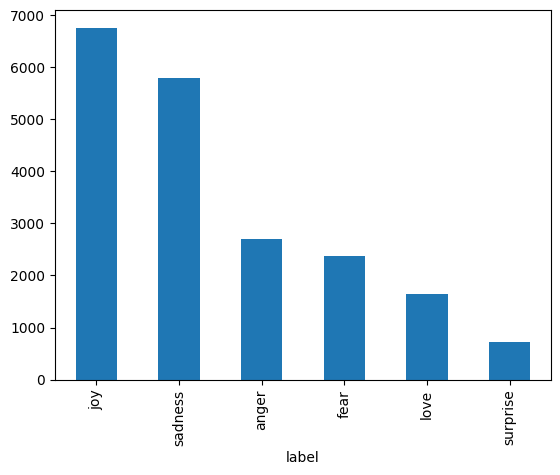

In [41]:
import matplotlib.pyplot as plt
df['label'].value_counts().plot(kind='bar')

Too solve this, we could create a balanced model by adding more data (augmenting) or reduce the overrepresented samples (equalization).

---

# Model #2 - Equalized Dataset

To balance the model and reduce skewness, we slice the dataset.

In [42]:
min_samples = 1641

label_counts = df['label'].value_counts()
df2 = pd.DataFrame(columns=df.columns)

for label in label_counts.index:
    label_data = df[df['label'] == label]

    if len(label_data) > min_samples:
        label_data = label_data.sample(min_samples, random_state=42)

    df2 = pd.concat([df2, label_data])

df2 = df2.reset_index(drop=True)

df2.shape

(8924, 3)

<Axes: xlabel='label'>

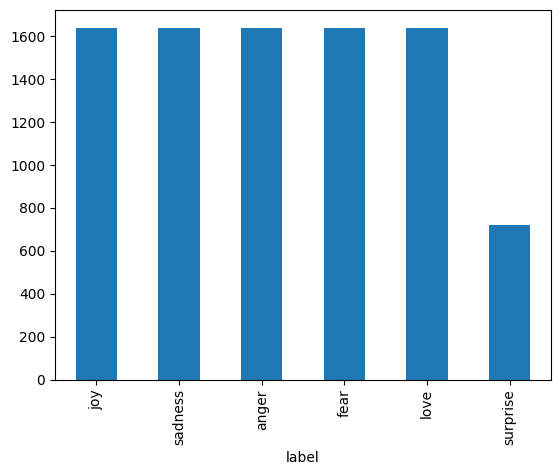

In [43]:
df2['label'].value_counts().plot(kind='bar')

Pros of this method: It's fast.<br>
Cons of this method: It's random. We might remove good accurate data and keep bad. For reproducibility a random_state is added to the `sample()`. We might want to change the random state if the model performs bad, rather than manually selecting rows.

'surprise' is still underrepresented, but I reducing all categories to just 719 samples would make more harm than good.

In [44]:
df2['text_clean'] = df2['text'].apply(lambda x: remove_words(x, common_words + url_elements))

In [45]:
df2['text_clean'] = df2['text_clean'].apply(lambda x:remove_words(x, stop_words+new_stop_words))

In [46]:
label_encoder = LabelEncoder()

integer_labels = label_encoder.fit_transform(df2['label'])
one_hot_labels = to_categorical(integer_labels)

assert len(one_hot_labels) == df2.shape[0]

In [47]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df2['text_clean'])
input_dim = len(tokenizer.word_index) + 1
input_dim

7287

In [48]:
input_length = max(len(sequence) for sequence in tokenizer.texts_to_sequences(df2['text_clean']))
input_length

51

In [49]:
model_1 = Sequential()
model_1.add(Embedding(input_dim=input_dim, output_dim=128, input_length=input_length))
model_1.add(GRU(64, dropout=0.2, recurrent_dropout=0.2))
model_1.add(Dense(6, activation='softmax'))
model_1.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

In [50]:
sequences = tokenizer.texts_to_sequences(df2['text_clean'])
X = pad_sequences(sequences, maxlen=input_length, padding='post', truncating='post')

X_train, X_test, y_train, y_test = train_test_split(X, one_hot_labels, test_size=0.0224, random_state=42, ) # 200 samples for testing

X_train.shape[0]*.2

1744.8000000000002

In [51]:
epochs = 24
batch_size = 16

history_eq = model_1.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2)

Epoch 1/24


437/437 [==============================] - 20s 37ms/step - loss: 1.7657 - accuracy: 0.1823 - val_loss: 1.7620 - val_accuracy: 0.1759
Epoch 2/24
437/437 [==============================] - 16s 36ms/step - loss: 1.7638 - accuracy: 0.1890 - val_loss: 1.7596 - val_accuracy: 0.1759
Epoch 3/24
437/437 [==============================] - 16s 36ms/step - loss: 1.7631 - accuracy: 0.1775 - val_loss: 1.7567 - val_accuracy: 0.1908
Epoch 4/24
437/437 [==============================] - 16s 36ms/step - loss: 1.7633 - accuracy: 0.1735 - val_loss: 1.7573 - val_accuracy: 0.1874
Epoch 5/24
437/437 [==============================] - 16s 37ms/step - loss: 1.7623 - accuracy: 0.1853 - val_loss: 1.7607 - val_accuracy: 0.1759
Epoch 6/24
437/437 [==============================] - 16s 38ms/step - loss: 1.7627 - accuracy: 0.1803 - val_loss: 1.7585 - val_accuracy: 0.1771
Epoch 7/24
437/437 [==============================] - 17s 38ms/step - loss: 1.7626 - accuracy: 0.1820 - val_loss: 1.7579 - val_accuracy: 0.1759
Epo

Yeah it's a bit overfit but that's ok.

In [52]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=list(range(1, epochs + 1)), y=history_eq.history['loss'], mode='lines', name='Training Loss'))
fig.add_trace(go.Scatter(x=list(range(1, epochs + 1)), y=history_eq.history['val_loss'], mode='lines', name='Validation Loss'))
fig.update_layout(title='Train and Val Loss', xaxis=dict(title='Epochs'), yaxis=dict(title='Loss'))
fig.show()

![](Assets/gru_plots/loss_2.png)

In [53]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=list(range(1, epochs + 1)), y=history_eq.history['accuracy'], mode='lines', name='Training Accuracy'))
fig.add_trace(go.Scatter(x=list(range(1, epochs + 1)), y=history_eq.history['val_accuracy'], mode='lines', name='Validation Accuracy'))
fig.update_layout(title='Training and Val Acc', xaxis=dict(title='Epochs'), yaxis=dict(title='Accuracy'))
fig.show()

![](Assets/gru_plots/loss_2.png)

In [54]:
evaluate_model(model_1, X_test, y_test)

7/7 [==============================] - 0s 12ms/step - loss: 0.7393 - accuracy: 0.8500
Test Loss: 0.7393
Test Accuracy: 85.00%


In [55]:
for i in a:
    predicted_label = predict_label(model_1, tokenizer, i.lower() + "very happy", input_length)
    print(f"Predicted Label: {predicted_label}")

1/1 [==============================] - 0s 371ms/step
Predicted Label: joy
1/1 [==============================] - 0s 27ms/step
Predicted Label: joy
1/1 [==============================] - 0s 29ms/step
Predicted Label: joy
1/1 [==============================] - 0s 30ms/step
Predicted Label: joy
1/1 [==============================] - 0s 33ms/step
Predicted Label: joy


In [56]:
for e, i in enumerate(sentences):
    predicted_label = predict_label(model_1, tokenizer, i.lower(), input_length)
    print(sentences[e])
    print(f"Predicted Label: {predicted_label}")

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 28ms/step
Beneath the fiery surface, frustration simmers like a rebellious volcano.
Predicted Label: anger
1/1 [==============================] - 0s 29ms/step
Raindrops trace silent pathways on the window, mirroring the quiet ache within.
Predicted Label: anger
1/1 [==============================] - 0s 29ms/step
Laughter weaves through the air, a vibrant tapestry of shared moments.
Predicted Label: joy
1/1 [==============================] - 0s 31ms/step
Hearts entwined, a cosmic dance of affection under the moonlit sky.
Predicted Label: sadness
1/1 [==============================] - 0s 28ms/step
In the shadowy corners, apprehension whispers its cautionary tale.
Predicted Label: joy
1/1 [==============================] - 0s 28ms/step
Unexpected ripples in the routine, a serendipitous waltz with the unknown.
Predicted Label: sadness


I mean it's ok. The example sentences are kind of vague. Let's try some lyrics.

In [57]:
df2['label'].value_counts()

label
joy         1641
sadness     1641
anger       1641
fear        1641
love        1641
surprise     719
Name: count, dtype: int64

In [58]:
lyrics = [
    "Bitch, I'ma kill you! You don't wanna fuck with me, Girls neither, you ain't nothin' but a slut to me", # anger
    "What?", "I couldn't even believe what I was reading", "I am surprised.", "oops i did it again",# surprise
    "You and me, baby, ain't nothin' but mammals So let's do it like they do on the Discovery Channel Do it again now You and me, baby, ain't nothin' but mammals So let's do it like they do on the Discovery Channel Gettin' horny now", # love
    "I wonder if I died, would tears come to her eyes, Forgive me for my disrespect, forgive me for my lies", # sadness
    "I guess I'm doin' well, Smokin' all the weed that I used to sell", "So what we get drunk, So what we smoke weed, We're just having fun, We don't care who sees, So what we go out, That's how it's supposed to be, Living young and wild and free", # joy
    "To find myself again My walls are closing in Without a sense of confidence, I'm convinced That there's just too much pressure to take I've felt this way before So insecure", #fear
]

In [59]:
for e, i in enumerate(lyrics):
    predicted_label = predict_label(model_1, tokenizer, i.lower(), input_length)
    print(lyrics[e])
    print(f"Predicted Label: {predicted_label}")

1/1 [==============================] - 0s 29ms/step
Bitch, I'ma kill you! You don't wanna fuck with me, Girls neither, you ain't nothin' but a slut to me
Predicted Label: sadness
1/1 [==============================] - 0s 28ms/step
What?
Predicted Label: sadness
1/1 [==============================] - 0s 28ms/step


I couldn't even believe what I was reading
Predicted Label: sadness
1/1 [==============================] - 0s 34ms/step
I am surprised.
Predicted Label: surprise
1/1 [==============================] - 0s 32ms/step
oops i did it again
Predicted Label: joy
1/1 [==============================] - 0s 32ms/step
You and me, baby, ain't nothin' but mammals So let's do it like they do on the Discovery Channel Do it again now You and me, baby, ain't nothin' but mammals So let's do it like they do on the Discovery Channel Gettin' horny now
Predicted Label: love
1/1 [==============================] - 0s 28ms/step
I wonder if I died, would tears come to her eyes, Forgive me for my disrespect, forgive me for my lies
Predicted Label: sadness
1/1 [==============================] - 0s 27ms/step
I guess I'm doin' well, Smokin' all the weed that I used to sell
Predicted Label: joy
1/1 [==============================] - 0s 32ms/step
So what we get drunk, So what we smoke weed, We're just having fun, We do

'surprise' is a tough one. Apart from than that, the model is pretty solid.

Rows of Interest

| Row  | Text | Label |
| ---  | ---- | ----- |
| 5578 | i now don t want to feel slutty | love
|12380 | i gotta feeling da bul taewuhbeoryeo burn it up i gotta feeling niga ulbujitneun nal ah neoneun wiheomhae gal ttaekkaji gatsseo get away woooo becuz i m cuz i m dangerous b | anger
| 16503 | i do not feel insecure or unsafe | fear
| 18330 | i more important than going fun ipad strategy games original boots from ugg wear ugg boots this winter low cost ugg boots uggs need to get washed inside they are also lightweight so you won t feel burdened with them speed up finances with payday loans payday loans the monthly solution for you | sadness